In [0]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from matplotlib import pyplot as plt
import time
%matplotlib inline

In [0]:
def simple_kernel(A,B):
    return A @ np.matrix(B).getH()

In [0]:
def gaussian_kernel(A, B, c):
    p = A.shape[1]
    if B.shape[1]!=p:
        raise ValueError("Shapes mismatch: A.shape[1]="+str(A.shape[1])+"!="+str(B.shape[1])+"=B.shape[1]")
    s = np.ones((A.shape[0], B.shape[0]))

    for i in range(p):
        ii, jj = np.meshgrid(B[:, i], A[:, i])
        s *= np.exp(-((ii-jj)**2)/c)
    return s

In [0]:
def landmark_points_choice(X, m, landmark_points_choice_algorithm):
    if m>X.shape[0]:
        raise ValueError("m must be not greater than X.shape[0], got m="+str(m)+">"+str(X.shape[0])+"=X.shape[0]")
    
    #forming Z as m uniformly randomly chosen X_i
    if landmark_points_choice_algorithm == "Uniform":
        chosen_indexes = np.random.choice(X.shape[0], m, replace=False)
        return X[chosen_indexes, :]
    
    #forming Z as centers of m clusters from K-means clusterization of X
    elif landmark_points_choice_algorithm == "K-means":
        KM = KMeans(n_clusters=m, max_iter=10)
        KM.fit(X)
        return KM.cluster_centers_
    
    else:
        raise ValueError("landmark_points_choice_algorithm must be 'Uniform' or 'K-means', got"
                         " %s" % str(landmark_points_choice_algorithm))

![Standard_Nystrom](files/Alg_1.png "Title")

# Standard Nystrom

In [0]:
def standard_nystrom(X, Z, kernel_function, r):
    m=Z.shape[0]
    n=X.shape[0]
    if r>m:
        raise ValueError("r must be not greater than m, got r="+str(r)+">"+str(m)+"=Z.shape[0]=m")
    if m>n:
        raise ValueError("m must be not greater than n, got m="+str(m)+">"+str(n)+"=X.shape[0]=n")
    
    #forming C and W
    C = kernel_function(X, Z)
    W = kernel_function(Z, Z)

    #EVD
    eigenValues, eigenVectors = np.linalg.eig(W)
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    #matrix L
    L = C @ eigenVectors[:, :r] @ fractional_matrix_power(np.linalg.pinv(np.diag(eigenValues[:r])), 1/2)
    
    #EVD
    eigenValues, eigenVectors = np.linalg.eig(np.matrix(L).getH() @ L)
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    sigma_hat = np.diag(eigenValues)
    
    #results
    Ur = L @ eigenVectors @ fractional_matrix_power(np.linalg.pinv(sigma_hat), 1/2)
    return Ur, sigma_hat

![Standard_Nystrom](files/Alg_2.png "Title")

# Imroved Nystrom via QR

In [0]:
def improved_nystrom(X, Z, kernel_function, r):
    m=Z.shape[0]
    n=X.shape[0]
    if r>m:
        raise ValueError("r must be not greater than m, got r="+str(r)+">"+str(m)+"=Z.shape[0]=m")
    if m>n:
        raise ValueError("m must be not greater than n, got m="+str(m)+">"+str(n)+"=X.shape[0]=n")
    
    # Form C and W
    C = kernel_function(X, Z)
    W = kernel_function(Z, Z)
    
    # Perform QR
    Q, R = np.linalg.qr(C)

    # Compute EVD
    eigenValues, eigenVectors = np.linalg.eig(R @ np.linalg.pinv(W) @ np.matrix(R).getH())
    idx = eigenValues.argsort()[::-1][:r]  
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    # Optimal parameters
    return Q @ eigenVectors, np.diag(eigenValues)

# Experiments on random sample

## Dataset initialization, kernel matrix, EVD approximation, Frobenius and trace norms

In [7]:
%%time
X = np.random.rand(100, 4) #n=100, p=4
r = 2
#Computing the parameter c for gaussian kernel as the average squared distance between all pairs of X_i:
c = 2*np.mean(np.var(X, axis=0))

#Gaussian kernel with pre-computed c:
def THE_gaussian_kernel(A, B):
    return gaussian_kernel(A, B, c)

# Computing kernel matrix
K = THE_gaussian_kernel(X, X)
norma_f = np.linalg.norm(K, 'f') #denominator for the relative error in Frobenius norm
norma_t = np.trace(K) #denominator for the relative error in trace norm

# Computing EVD approximation:
eigenValues, eigenVectors = np.linalg.eig(K)
idx = eigenValues.argsort()[::-1][:r]  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
G_evd = eigenVectors @np.diag(eigenValues) @ np.matrix(eigenVectors).getH()

#Relative errors of EVD in Frobenius and trace norms:
error_evd = {'Frob': np.linalg.norm(K - G_evd, 'f') / norma_f, 'Trace': np.trace(K - G_evd) / norma_t}

CPU times: user 13.5 ms, sys: 9.48 ms, total: 23 ms
Wall time: 13.3 ms


## Averaging error for different choices of landmark points

In [8]:
%%time

n_iter = 50
errors_stand = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
errors_opt = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
list_times_st = {'Uniform': [], 'K-means': []}
list_times_opt = {'Uniform': [], 'K-means': []}

for k in range(n_iter):
    for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
        error_stand = {'Frob': [], 'Trace': []}
        error_opt = {'Frob': [], 'Trace': []}
        list_m = []
        list_time_st = {'Uniform': [], 'K-means': []}
        list_time_opt = {'Uniform': [], 'K-means': []}
        for m in range(r, r*6, r):
            Z = landmark_points_choice(X, m, landmark_points_choice_algorithm)
            list_m.append(m)

            #Relative errors of the Standard Nystrom in Frobenius and trace norms:
            x1 = time.time()
            U, Lam = standard_nystrom(X, Z, THE_gaussian_kernel, r)
            x2 = time.time()
            time_st = x2 - x1
            list_time_st[landmark_points_choice_algorithm].append(time_st)
            G_st = U @ Lam @ np.matrix(U).getH()
            error_stand['Frob'].append(np.linalg.norm(K - G_st, 'f') / norma_f)
            error_stand['Trace'].append(np.trace(K - G_st) / norma_t)

            #Relative errors of the optimized Nystrom in Frobenius and trace norms:
            x3 = time.time()
            U_opt, Lam_opt = improved_nystrom(X, Z, THE_gaussian_kernel, r)
            x4 = time.time()
            time_opt = x4 - x3
            list_time_opt[landmark_points_choice_algorithm].append(time_opt)
            G_opt = U_opt @ Lam_opt @ np.matrix(U_opt).getH()
            error_opt['Frob'].append(np.linalg.norm(K - G_opt, 'f') / norma_f)
            error_opt['Trace'].append(np.trace(K - G_opt) / norma_t)
            
        list_times_st[landmark_points_choice_algorithm].append(list_time_st[landmark_points_choice_algorithm])
        list_times_opt[landmark_points_choice_algorithm].append(list_time_opt[landmark_points_choice_algorithm])
            
        for nrm in error_evd.keys():
            errors_stand[landmark_points_choice_algorithm, nrm].append(error_stand[nrm])
            errors_opt[landmark_points_choice_algorithm, nrm].append(error_opt[nrm])

CPU times: user 8.33 s, sys: 14.7 ms, total: 8.34 s
Wall time: 8.35 s


## Visualization

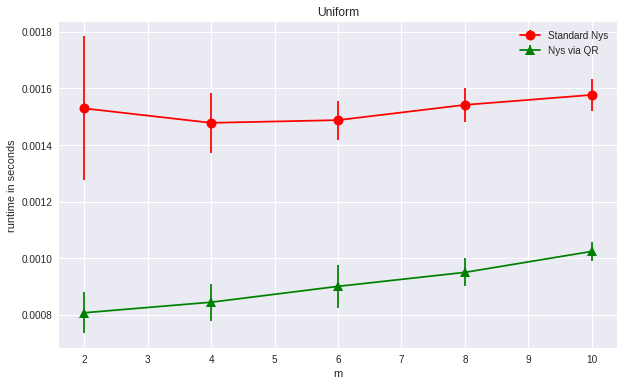

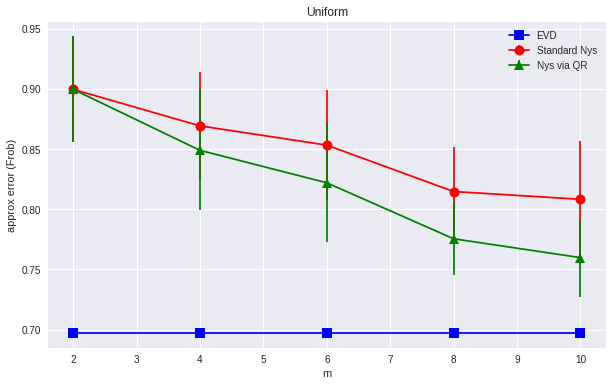

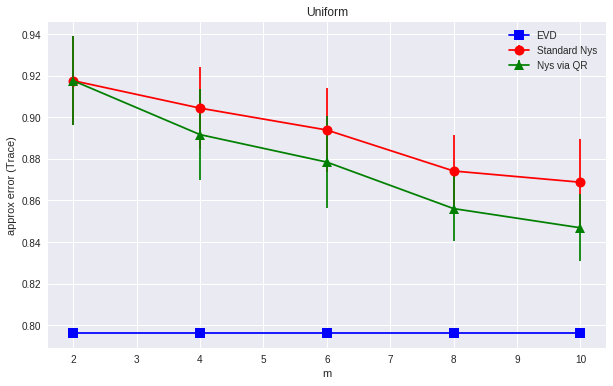

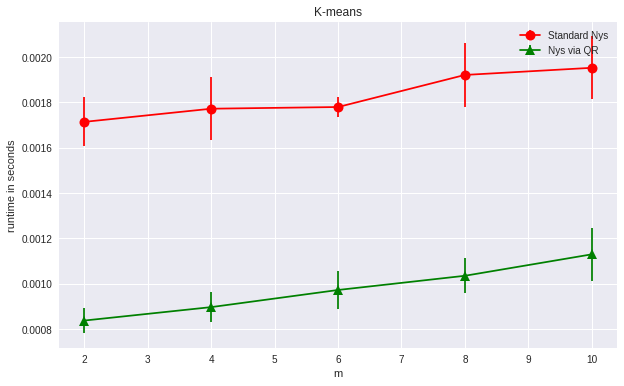

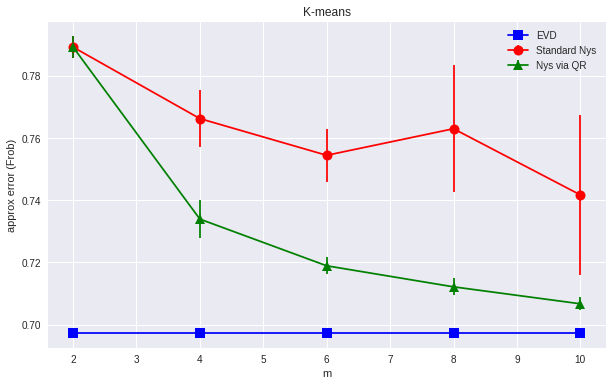

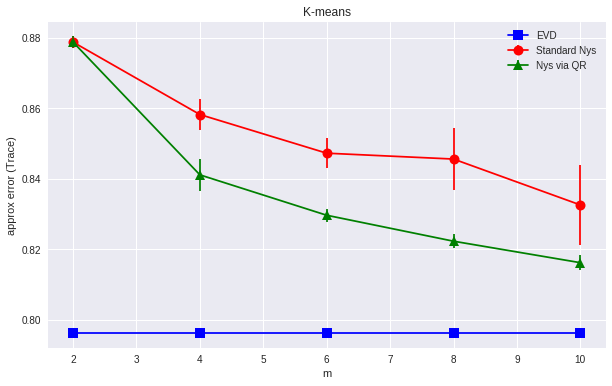

In [9]:
for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
    
    plt.figure(figsize = (10, 6))
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_st[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_st[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'r', color = 'r',
                 capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'g', color = 'g',
                 capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
    plt.grid(True)
    plt.title(landmark_points_choice_algorithm)
    plt.ylabel('runtime in seconds')
    plt.xlabel('m')
    plt.legend(['Standard Nys', 'Nys via QR'], loc=1)
    plt.show()
    
    
    for nrm in error_evd.keys():
        plt.figure(figsize = (10, 6))
        plt.errorbar(x=list_m,
                     y=[error_evd[nrm]]*len(list_m),
                     yerr = np.zeros(len(list_m)),
                     ecolor = 'b', color = 'b',
                     capsize = 0, marker='s',markeredgecolor='b', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'r', color = 'r',
                     capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'g', color = 'g',
                     capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
        plt.grid(True)
        plt.title(landmark_points_choice_algorithm)
        plt.ylabel('approx error ('+nrm+')')
        plt.xlabel('m')
        plt.legend(['EVD', 'Standard Nys', 'Nys via QR'], loc=1)
        plt.show()

# Nystrom via SVD

# Experiments on random sample

## Dataset initialization, kernel matrix, EVD approximation, Frobenius and trace norms

In [10]:
%%time
X = np.random.rand(100, 4) #n=100, p=4
r = 2
#Computing the parameter c for gaussian kernel as the average squared distance between all pairs of X_i:
c = 2*np.mean(np.var(X, axis=0))

#Gaussian kernel with pre-computed c:
def THE_gaussian_kernel(A, B):
    return gaussian_kernel(A, B, c)

# Computing kernel matrix
K = THE_gaussian_kernel(X, X)
norma_f = np.linalg.norm(K, 'f') #denominator for the relative error in Frobenius norm
norma_t = np.trace(K) #denominator for the relative error in trace norm

# Computing EVD approximation:
eigenValues, eigenVectors = np.linalg.eig(K)
idx = eigenValues.argsort()[::-1][:r]  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
G_evd = eigenVectors @np.diag(eigenValues) @ np.matrix(eigenVectors).getH()

#Relative errors of EVD in Frobenius and trace norms:
error_evd = {'Frob': np.linalg.norm(K - G_evd, 'f') / norma_f, 'Trace': np.trace(K - G_evd) / norma_t}

CPU times: user 17.6 ms, sys: 6.78 ms, total: 24.3 ms
Wall time: 20.3 ms


In [0]:
def nystrom_svd(X, Z, kernel_function, r):
    m=Z.shape[0]
    n=X.shape[0]
    if r>m:
        raise ValueError("r must be not greater than m, got r="+str(r)+">"+str(m)+"=Z.shape[0]=m")
    if m>n:
        raise ValueError("m must be not greater than n, got m="+str(m)+">"+str(n)+"=X.shape[0]=n")
    
    #forming C and W
    C = kernel_function(X, Z)
    W = kernel_function(Z, Z)
    
    #SVD
    u, s, vh = np.linalg.svd(C)
    sigma = np.diag(s)
    if len(s) < u.shape[1]:
        zeros = np.zeros((u.shape[1]-len(s),len(s)))
        sigma_big = np.vstack((sigma,zeros))
        
    #EVD
    #print (sigma.shape, vh.shape, np.linalg.pinv(W).shape, np.matrix(vh).getH().shape)
    matrix = sigma_big @ vh @ np.linalg.pinv(W) @ np.matrix(vh).getH() @ sigma
    
    eigenValues, eigenVectors = np.linalg.eig(matrix[:matrix.shape[1]])
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    #results
    U_opt = u[:,:eigenVectors.shape[0]] @ eigenVectors[:, :r]
    lambda_opt = np.diag(eigenValues)[:r,:r]
    return U_opt, lambda_opt

## Averaging error for different choices of landmark points

In [12]:
%%time

n_iter = 50
errors_stand = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
errors_opt = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
list_times_st = {'Uniform': [], 'K-means': []}
list_times_opt = {'Uniform': [], 'K-means': []}

for k in range(n_iter):
    for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
        error_stand = {'Frob': [], 'Trace': []}
        error_opt = {'Frob': [], 'Trace': []}
        list_m = []
        list_time_st = {'Uniform': [], 'K-means': []}
        list_time_opt = {'Uniform': [], 'K-means': []}
        for m in range(r, r*6, r):
            Z = landmark_points_choice(X, m, landmark_points_choice_algorithm)
            list_m.append(m)

            #Relative errors of the Standard Nystrom in Frobenius and trace norms:
            x1 = time.time()
            U, Lam = standard_nystrom(X, Z, THE_gaussian_kernel, r)
            x2 = time.time()
            time_st = x2 - x1
            list_time_st[landmark_points_choice_algorithm].append(time_st)
            G_st = U @ Lam @ np.matrix(U).getH()
            error_stand['Frob'].append(np.linalg.norm(K - G_st, 'f') / norma_f)
            error_stand['Trace'].append(np.trace(K - G_st) / norma_t)

            #Relative errors of the optimized Nystrom in Frobenius and trace norms:
            x3 = time.time()
            U_opt, Lam_opt = nystrom_svd(X, Z, THE_gaussian_kernel, r)
            x4 = time.time()
            time_opt = x4 - x3
            list_time_opt[landmark_points_choice_algorithm].append(time_opt)
            G_opt = U_opt @ Lam_opt @ np.matrix(U_opt).getH()
            error_opt['Frob'].append(np.linalg.norm(K - G_opt, 'f') / norma_f)
            error_opt['Trace'].append(np.trace(K - G_opt) / norma_t)
            
        list_times_st[landmark_points_choice_algorithm].append(list_time_st[landmark_points_choice_algorithm])
        list_times_opt[landmark_points_choice_algorithm].append(list_time_opt[landmark_points_choice_algorithm])
            
        for nrm in error_evd.keys():
            errors_stand[landmark_points_choice_algorithm, nrm].append(error_stand[nrm])
            errors_opt[landmark_points_choice_algorithm, nrm].append(error_opt[nrm])

CPU times: user 14.1 s, sys: 7.62 s, total: 21.7 s
Wall time: 10.9 s


## Visualization

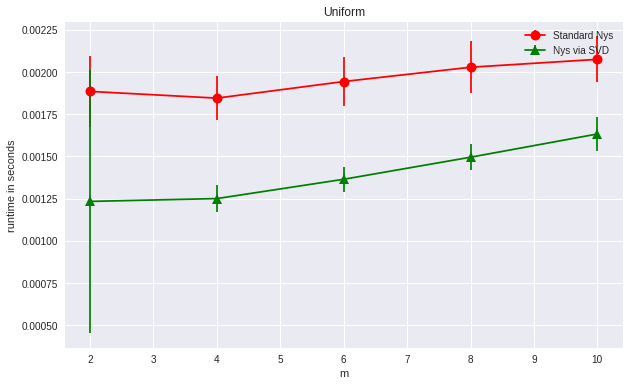

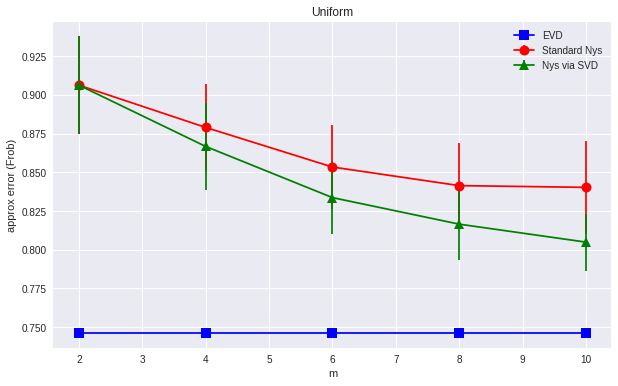

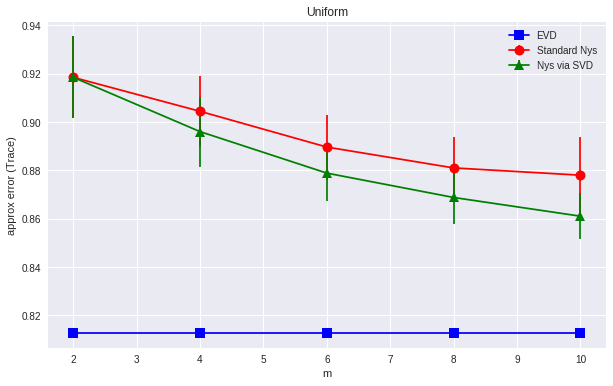

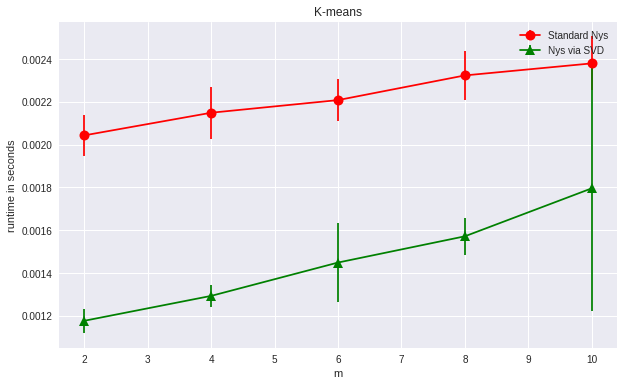

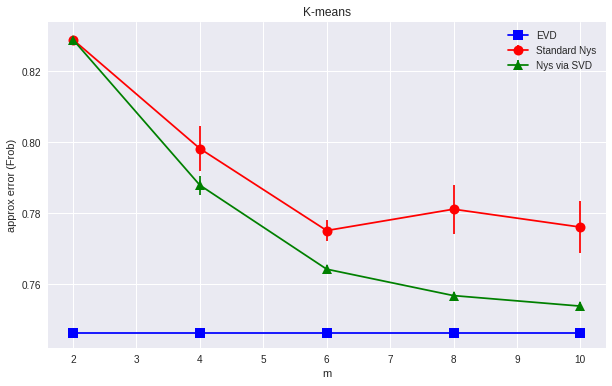

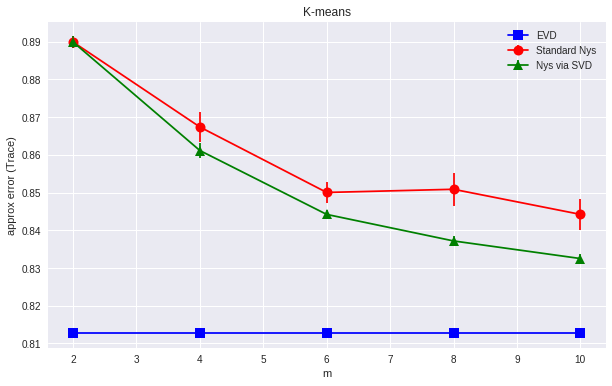

In [13]:
for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
    
    plt.figure(figsize = (10, 6))
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_st[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_st[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'r', color = 'r',
                 capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'g', color = 'g',
                 capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
    plt.grid(True)
    plt.title(landmark_points_choice_algorithm)
    plt.ylabel('runtime in seconds')
    plt.xlabel('m')
    plt.legend(['Standard Nys', 'Nys via SVD'], loc=1)
    plt.show()
    
    
    for nrm in error_evd.keys():
        plt.figure(figsize = (10, 6))
        plt.errorbar(x=list_m,
                     y=[error_evd[nrm]]*len(list_m),
                     yerr = np.zeros(len(list_m)),
                     ecolor = 'b', color = 'b',
                     capsize = 0, marker='s',markeredgecolor='b', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'r', color = 'r',
                     capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'g', color = 'g',
                     capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
        plt.grid(True)
        plt.title(landmark_points_choice_algorithm)
        plt.ylabel('approx error ('+nrm+')')
        plt.xlabel('m')
        plt.legend(['EVD', 'Standard Nys', 'Nys via SVD'], loc=1)
        plt.show()

# Experiments on real datasets - pendigits

In [14]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving pendigits.tes to pendigits (2).tes
Saving pendigits.tra to pendigits (3).tra


In [15]:
Data = pd.concat([pd.read_csv('pendigits.tra', header=None), pd.read_csv('pendigits.tes', header=None)], ignore_index=True)
Data.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
10987,36,100,24,70,0,38,49,33,95,47,87,55,96,21,100,0,4
10988,16,75,41,100,52,64,32,27,0,0,21,9,62,2,100,14,2
10989,56,100,27,79,0,39,12,0,66,15,100,51,93,93,38,93,0
10990,19,100,0,61,3,23,48,0,97,27,100,66,62,97,10,81,0
10991,38,100,37,81,12,55,0,28,52,27,100,42,86,26,65,0,4


In [16]:
Data = np.array(Data)
Data.shape
#Data=Data.head(500)

(10992, 17)

In [17]:
X = Data[:500, :-1] #the last column contains label
X.shape

(500, 16)

In [18]:
%%time
r = 2
#Computing the parameter c for gaussian kernel as the average squared distance between all pairs of X_i:
c = 2*np.mean(np.var(X, axis=0))

#Gaussian kernel with pre-computed c:
def THE_gaussian_kernel(A, B):
    return gaussian_kernel(A, B, c)

# Computing kernel matrix
K = THE_gaussian_kernel(X, X)
norma_f = np.linalg.norm(K, 'f') #denominator for the relative error in Frobenius norm
norma_t = np.trace(K) #denominator for the relative error in trace norm

# Computing EVD approximation:
eigenValues, eigenVectors = np.linalg.eig(K)
idx = eigenValues.argsort()[::-1][:r]  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
G_evd = eigenVectors @np.diag(eigenValues) @ np.matrix(eigenVectors).getH()

#Relative errors of EVD in Frobenius and trace norms:
error_evd = {'Frob': np.linalg.norm(K - G_evd, 'f') / norma_f, 'Trace': np.trace(K - G_evd) / norma_t}

CPU times: user 614 ms, sys: 178 ms, total: 791 ms
Wall time: 470 ms
Parser   : 123 ms


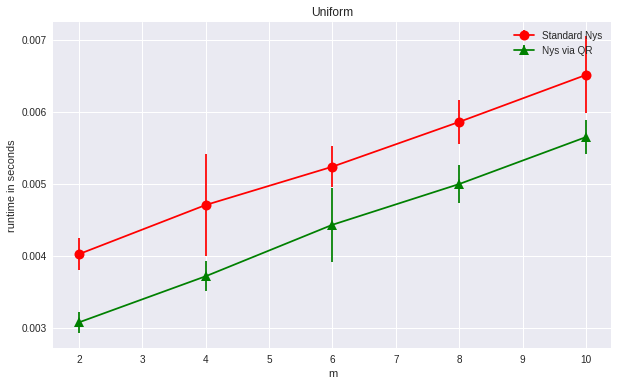

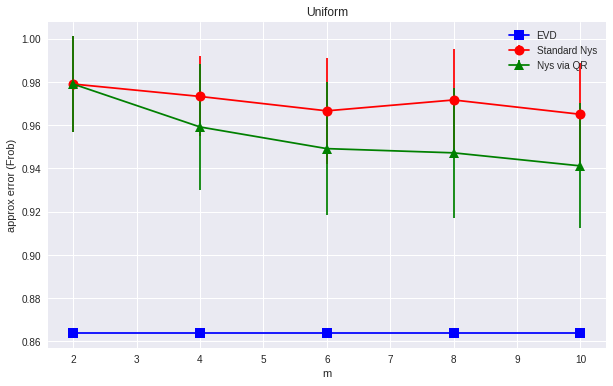

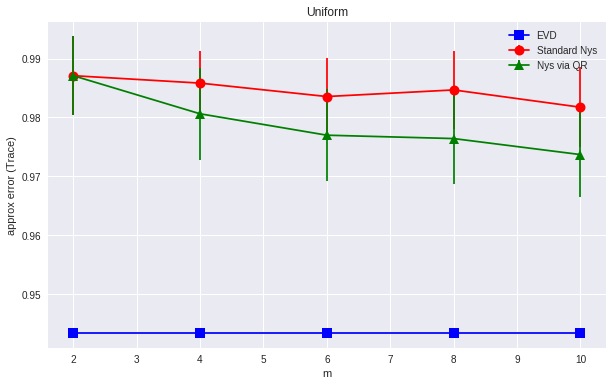

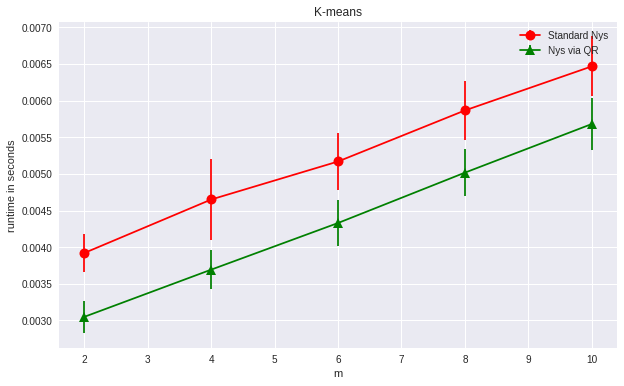

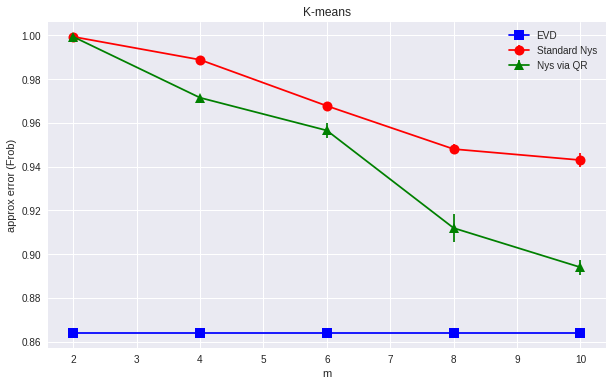

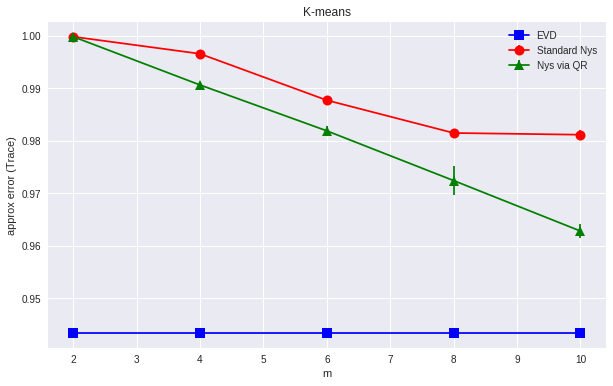

CPU times: user 29.3 s, sys: 14.7 s, total: 44 s
Wall time: 22.2 s


In [19]:
%%time

n_iter = 50
errors_stand = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
errors_opt = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
list_times_st = {'Uniform': [], 'K-means': []}
list_times_opt = {'Uniform': [], 'K-means': []}

for k in range(n_iter):
    for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
        error_stand = {'Frob': [], 'Trace': []}
        error_opt = {'Frob': [], 'Trace': []}
        list_m = []
        list_time_st = {'Uniform': [], 'K-means': []}
        list_time_opt = {'Uniform': [], 'K-means': []}
        for m in range(r, r*6, r):
            Z = landmark_points_choice(X, m, landmark_points_choice_algorithm)
            list_m.append(m)

            #Relative errors of the Standard Nystrom in Frobenius and trace norms:
            x1 = time.time()
            U, Lam = standard_nystrom(X, Z, THE_gaussian_kernel, r)
            x2 = time.time()
            time_st = x2 - x1
            list_time_st[landmark_points_choice_algorithm].append(time_st)
            G_st = U @ Lam @ np.matrix(U).getH()
            error_stand['Frob'].append(np.linalg.norm(K - G_st, 'f') / norma_f)
            error_stand['Trace'].append(np.trace(K - G_st) / norma_t)

            #Relative errors of the optimized Nystrom in Frobenius and trace norms:
            x3 = time.time()
            U_opt, Lam_opt = improved_nystrom(X, Z, THE_gaussian_kernel, r)
            x4 = time.time()
            time_opt = x4 - x3
            list_time_opt[landmark_points_choice_algorithm].append(time_opt)
            G_opt = U_opt @ Lam_opt @ np.matrix(U_opt).getH()
            error_opt['Frob'].append(np.linalg.norm(K - G_opt, 'f') / norma_f)
            error_opt['Trace'].append(np.trace(K - G_opt) / norma_t)
            
        list_times_st[landmark_points_choice_algorithm].append(list_time_st[landmark_points_choice_algorithm])
        list_times_opt[landmark_points_choice_algorithm].append(list_time_opt[landmark_points_choice_algorithm])
            
        for nrm in error_evd.keys():
            errors_stand[landmark_points_choice_algorithm, nrm].append(error_stand[nrm])
            errors_opt[landmark_points_choice_algorithm, nrm].append(error_opt[nrm])

for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
    
    plt.figure(figsize = (10, 6))
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_st[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_st[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'r', color = 'r',
                 capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'g', color = 'g',
                 capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
    plt.grid(True)
    plt.title(landmark_points_choice_algorithm)
    plt.ylabel('runtime in seconds')
    plt.xlabel('m')
    plt.legend(['Standard Nys', 'Nys via QR'], loc=1)
    plt.show()
    
    
    for nrm in error_evd.keys():
        plt.figure(figsize = (10, 6))
        plt.errorbar(x=list_m,
                     y=[error_evd[nrm]]*len(list_m),
                     yerr = np.zeros(len(list_m)),
                     ecolor = 'b', color = 'b',
                     capsize = 0, marker='s',markeredgecolor='b', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'r', color = 'r',
                     capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'g', color = 'g',
                     capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
        plt.grid(True)
        plt.title(landmark_points_choice_algorithm)
        plt.ylabel('approx error ('+nrm+')')
        plt.xlabel('m')
        plt.legend(['EVD', 'Standard Nys', 'Nys via QR'], loc=1)
        plt.show()

In [0]:
# Experiments on real datasets - satimage

In [21]:
from google.colab import files
uploaded = files.upload()

Saving sat.trn to sat.trn
Saving sat.tst to sat.tst


In [22]:
Data = pd.concat([pd.read_csv('sat.trn', sep=' ', header=None), pd.read_csv('sat.tst', sep=' ', header=None)], ignore_index=True)
Data.tail()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
6430,60,83,96,85,64,87,100,88,64,83,...,92,66,87,108,89,63,83,104,85,1
6431,64,79,100,85,56,71,96,85,56,68,...,85,66,83,100,85,63,83,100,81,1
6432,56,68,91,81,56,64,91,81,53,64,...,81,59,87,96,81,63,83,92,74,5
6433,56,68,87,74,60,71,91,81,60,64,...,74,59,83,92,74,59,83,92,70,5
6434,60,71,91,81,60,64,104,99,56,64,...,74,59,83,92,70,63,79,108,92,5


In [0]:
Data = np.array(Data)

In [24]:
X = Data[:500, :-1] #the last column contains label
X.shape

(500, 36)

In [25]:
%%time
r = 2
#Computing the parameter c for gaussian kernel as the average squared distance between all pairs of X_i:
c = 2*np.mean(np.var(X, axis=0))

#Gaussian kernel with pre-computed c:
def THE_gaussian_kernel(A, B):
    return gaussian_kernel(A, B, c)

# Computing kernel matrix
K = THE_gaussian_kernel(X, X)
norma_f = np.linalg.norm(K, 'f') #denominator for the relative error in Frobenius norm
norma_t = np.trace(K) #denominator for the relative error in trace norm

# Computing EVD approximation:
eigenValues, eigenVectors = np.linalg.eig(K)
idx = eigenValues.argsort()[::-1][:r]  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
G_evd = eigenVectors @np.diag(eigenValues) @ np.matrix(eigenVectors).getH()

#Relative errors of EVD in Frobenius and trace norms:
error_evd = {'Frob': np.linalg.norm(K - G_evd, 'f') / norma_f, 'Trace': np.trace(K - G_evd) / norma_t}

CPU times: user 826 ms, sys: 197 ms, total: 1.02 s
Wall time: 672 ms


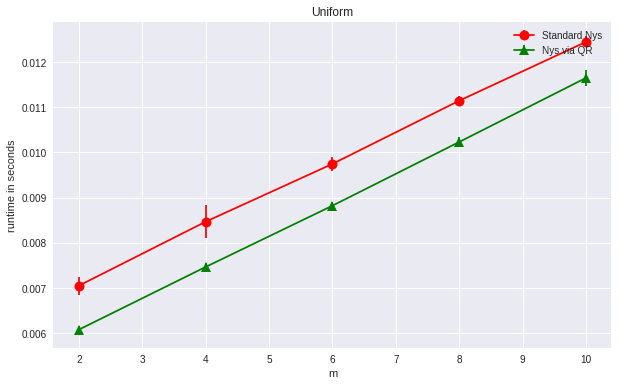

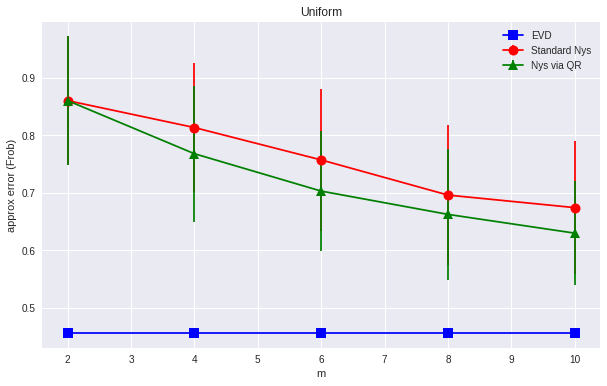

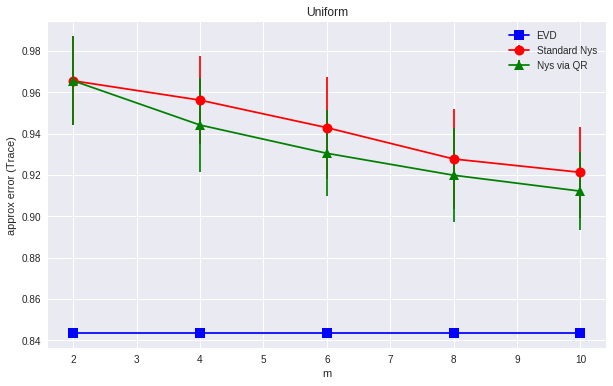

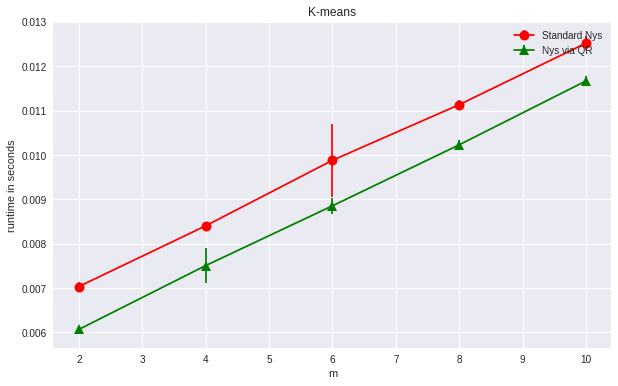

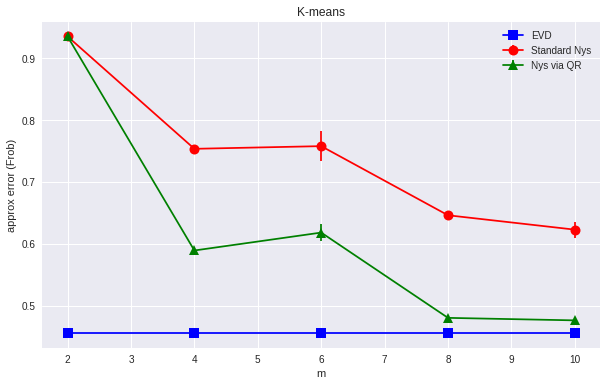

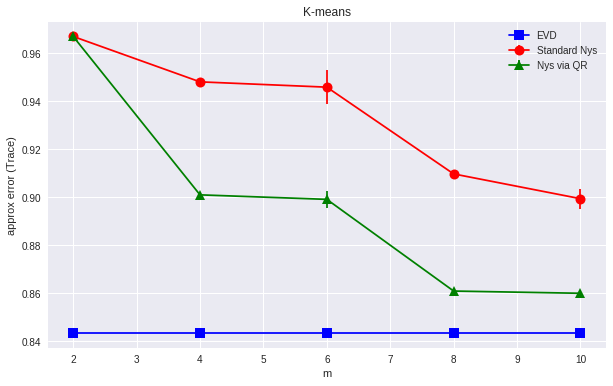

CPU times: user 37.2 s, sys: 19.6 s, total: 56.8 s
Wall time: 28.8 s


In [26]:
%%time

n_iter = 50
errors_stand = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
errors_opt = {('Uniform', 'Frob'): [], ('Uniform', 'Trace'): [], ('K-means', 'Frob'): [], ('K-means', 'Trace'): []}
list_times_st = {'Uniform': [], 'K-means': []}
list_times_opt = {'Uniform': [], 'K-means': []}

for k in range(n_iter):
    for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
        error_stand = {'Frob': [], 'Trace': []}
        error_opt = {'Frob': [], 'Trace': []}
        list_m = []
        list_time_st = {'Uniform': [], 'K-means': []}
        list_time_opt = {'Uniform': [], 'K-means': []}
        for m in range(r, r*6, r):
            Z = landmark_points_choice(X, m, landmark_points_choice_algorithm)
            list_m.append(m)

            #Relative errors of the Standard Nystrom in Frobenius and trace norms:
            x1 = time.time()
            U, Lam = standard_nystrom(X, Z, THE_gaussian_kernel, r)
            x2 = time.time()
            time_st = x2 - x1
            list_time_st[landmark_points_choice_algorithm].append(time_st)
            G_st = U @ Lam @ np.matrix(U).getH()
            error_stand['Frob'].append(np.linalg.norm(K - G_st, 'f') / norma_f)
            error_stand['Trace'].append(np.trace(K - G_st) / norma_t)

            #Relative errors of the optimized Nystrom in Frobenius and trace norms:
            x3 = time.time()
            U_opt, Lam_opt = improved_nystrom(X, Z, THE_gaussian_kernel, r)
            x4 = time.time()
            time_opt = x4 - x3
            list_time_opt[landmark_points_choice_algorithm].append(time_opt)
            G_opt = U_opt @ Lam_opt @ np.matrix(U_opt).getH()
            error_opt['Frob'].append(np.linalg.norm(K - G_opt, 'f') / norma_f)
            error_opt['Trace'].append(np.trace(K - G_opt) / norma_t)
            
        list_times_st[landmark_points_choice_algorithm].append(list_time_st[landmark_points_choice_algorithm])
        list_times_opt[landmark_points_choice_algorithm].append(list_time_opt[landmark_points_choice_algorithm])
            
        for nrm in error_evd.keys():
            errors_stand[landmark_points_choice_algorithm, nrm].append(error_stand[nrm])
            errors_opt[landmark_points_choice_algorithm, nrm].append(error_opt[nrm])

for landmark_points_choice_algorithm in ['Uniform', 'K-means']:
    
    plt.figure(figsize = (10, 6))
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_st[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_st[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'r', color = 'r',
                 capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
    plt.errorbar(x=list_m,
                 y=np.mean(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 yerr = np.std(list_times_opt[landmark_points_choice_algorithm], axis=0),
                 ecolor = 'g', color = 'g',
                 capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
    plt.grid(True)
    plt.title(landmark_points_choice_algorithm)
    plt.ylabel('runtime in seconds')
    plt.xlabel('m')
    plt.legend(['Standard Nys', 'Nys via QR'], loc=1)
    plt.show()
    
    
    for nrm in error_evd.keys():
        plt.figure(figsize = (10, 6))
        plt.errorbar(x=list_m,
                     y=[error_evd[nrm]]*len(list_m),
                     yerr = np.zeros(len(list_m)),
                     ecolor = 'b', color = 'b',
                     capsize = 0, marker='s',markeredgecolor='b', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_stand[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'r', color = 'r',
                     capsize = 5, marker='o',markeredgecolor='r', markersize = 10)
        plt.errorbar(x=list_m,
                     y=np.mean(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     yerr = np.std(errors_opt[landmark_points_choice_algorithm, nrm], axis=0),
                     ecolor = 'g', color = 'g',
                     capsize = 5, marker='^',markeredgecolor='g', markersize = 10)
        plt.grid(True)
        plt.title(landmark_points_choice_algorithm)
        plt.ylabel('approx error ('+nrm+')')
        plt.xlabel('m')
        plt.legend(['EVD', 'Standard Nys', 'Nys via QR'], loc=1)
        plt.show()